# Financial Profiles Clustering: Identifying Patterns in Corporate Financial Health

## Introduction

Analyzing financial statements is very important for making investment decisions, checking company risks, and comparing businesses. But because thousands of companies report financial results every year, it’s hard to spot patterns and group similar companies. Usually, companies get grouped by industry or manually, but this method can miss financial similarities that cross industry lines.

This project asks a key question: **Can we use unsupervised machine learning to automatically find groups of companies with similar financial profiles?** We do this by looking at important financial ratios for many companies to find clusters—groups of companies that have similar financial health, risks, or efficiency.

The results can help investors find companies with similar risk and return, help regulators see big-picture trends, and let companies compare themselves to others with similar financial setups, even if they’re in different industries.


## Understanding Clustering

Clustering is a type of machine learning that groups data points based on how similar they are without labels or categories needed in advance. The main goal is to find natural groupings and hidden patterns in data.

### How Clustering Works

Clustering algorithms look at the “distance” or similarity between data points (here, companies with similar financial ratios will be close together, and very different ones will be far apart).

**K-Means Clustering** is very popular:
- Splits data into k groups by assigning each point to the nearest group center (“centroid”)
- Tries to make clusters as tight and close as possible
- You have to choose the number of clusters (k) ahead of time
- Works best when groups are round and similar in size

**Hierarchical Clustering** (Agglomerative) works differently:
- Starts by putting each data point in its own group, then combines the most similar groups step by step
- Creates a branching tree (called a dendrogram) that shows how groups are related
- No need to pick the number of clusters in advance
- Good for showing the structure of the data, but can be slower on big datasets

**DBSCAN** (Density-Based Spatial Clustering) gives another option:
- Groups together points that are packed closely together (“dense” regions)
- Can detect weird-shaped clusters
- Labels points that don’t fit into any cluster as outliers (“noise”)
- No need to set the number of clusters beforehand

For our financial data, we’ll try out several of these methods to see which one best finds interesting company groupings.


## The Dataset

Our dataset consists of financial statement tables extracted from company filings, organized into five categories:

- **Balance Sheets** (282 files): Assets, liabilities, and equity information
- **Income Statements** (317 files): Revenue, expenses, and profitability metrics
- **Cash Flow Statements** (36 files): Operating, investing, and financing cash movements
- **Notes** (702 files): Detailed textual explanations and disclosures
- **Others** (1,236 files): Miscellaneous financial tables

**Total: 2,573 HTML table files**

Each file contains financial data in HTML table format, with company identifiers embedded in filenames (e.g., `18460658_57.html` where `18460658` is the company ID). The tables include quarterly and annual financial figures, with varying formats and structures across different companies.

Source for dataset: https://www.kaggle.com/datasets/drcrabkg/financial-statements-clustering/data

### Key Features We'll Extract

To perform meaningful clustering, we'll calculate 10 key financial ratios that capture different aspects of financial health:

1. **Current Ratio** (Current Assets / Current Liabilities) - Short-term liquidity measure
2. **Debt-to-Equity Ratio** (Total Debt / Shareholder Equity) - Leverage and financial risk indicator
3. **Net Profit Margin** (Net Income / Revenue) - Profitability efficiency
4. **Return on Assets** (Net Income / Total Assets) - Asset utilization efficiency
5. **Revenue Growth Rate** (Quarter-over-Quarter % change) - Business momentum
6. **Operating Cash Flow Ratio** (Operating Cash Flow / Current Liabilities) - Cash strength indicator
7. **Asset Turnover** (Revenue / Total Assets) - Operational efficiency
8. **Interest Coverage Ratio** (EBIT / Interest Expense) - Debt serviceability
9. **Gross Margin** (Gross Profit / Revenue) - Pricing power and cost structure
10. **Equity Growth Rate** (Change in Shareholder Equity % over quarters) - Capital accumulation

These ratios provide a comprehensive view of a company's financial position, profitability, efficiency, and growth trajectory.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from bs4 import BeautifulSoup
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)


## Data Extraction and Parsing

The first challenge is extracting structured financial data from HTML tables. Each file contains financial statements with varying formats, so we need a robust parser that can handle different table structures and identify key line items.


In [2]:
class FinancialTableParser:
    """Parser for extracting financial data from HTML tables"""
    
    def __init__(self):
        # Keywords for identifying financial line items
        self.keywords = {
            'current_assets': ['current assets', 'total current assets', 'current asset'],
            'current_liabilities': ['current liabilities', 'total current liabilities', 'current liability'],
            'total_assets': ['total assets', 'total asset'],
            'total_debt': ['total debt', 'borrowings', 'total borrowings', 'long term debt', 'short term debt'],
            'shareholder_equity': ['shareholder equity', 'total equity', 'equity', 'shareholders equity'],
            'revenue': ['revenue', 'total revenue', 'sales', 'total sales', 'income from operations'],
            'gross_profit': ['gross profit', 'gross income'],
            'net_income': ['net income', 'profit after tax', 'net profit', 'profit for the period'],
            'ebit': ['ebit', 'earnings before interest and tax', 'operating profit', 'profit before tax'],
            'interest_expense': ['interest expense', 'finance costs', 'interest costs'],
            'operating_cash_flow': ['operating cash flow', 'cash from operations', 'net cash from operating activities']
        }
    
    def parse_html(self, filepath):
        """Parse HTML file and extract table data"""
        try:
            with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            soup = BeautifulSoup(content, 'html.parser')
            tables = soup.find_all('table')
            return tables
        except Exception as e:
            return []
    
    def extract_text(self, element):
        """Extract text from HTML element, handling nested tags"""
        if element is None:
            return ""
        text = element.get_text(separator=' ', strip=True)
        return text.lower()
    
    def parse_number(self, text):
        """Parse numeric value from text, handling commas and parentheses"""
        if not text or text == '-':
            return None
        # Remove commas and other formatting
        text = str(text).replace(',', '').strip()
        # Handle parentheses as negative
        if '(' in text and ')' in text:
            text = '-' + text.replace('(', '').replace(')', '')
        # Extract numbers
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if numbers:
            try:
                return float(numbers[0])
            except:
                return None
        return None
    
    def find_line_item(self, tables, keywords):
        """Find a line item in tables using keyword matching"""
        for table in tables:
            rows = table.find_all('tr')
            for row in rows:
                cells = row.find_all(['td', 'th'])
                if len(cells) < 2:
                    continue
                
                # Check first cell for keywords
                first_cell_text = self.extract_text(cells[0])
                if any(keyword in first_cell_text for keyword in keywords):
                    # Try to extract numeric value from subsequent cells
                    for cell in cells[1:]:
                        value = self.parse_number(self.extract_text(cell))
                        if value is not None and abs(value) > 0.01:  # Ignore very small values
                            return abs(value)  # Use absolute value for most metrics
        return None
    
    def extract_company_data(self, filepath, statement_type):
        """Extract all relevant financial data from a file"""
        tables = self.parse_html(filepath)
        if not tables:
            return {}
        
        data = {}
        
        # Extract company ID from filename
        filename = Path(filepath).stem
        company_id = filename.split('_')[0]
        data['company_id'] = company_id
        data['statement_type'] = statement_type
        
        # Extract financial metrics based on statement type
        if statement_type == 'balance_sheet':
            data['current_assets'] = self.find_line_item(tables, self.keywords['current_assets'])
            data['current_liabilities'] = self.find_line_item(tables, self.keywords['current_liabilities'])
            data['total_assets'] = self.find_line_item(tables, self.keywords['total_assets'])
            data['total_debt'] = self.find_line_item(tables, self.keywords['total_debt'])
            data['shareholder_equity'] = self.find_line_item(tables, self.keywords['shareholder_equity'])
        
        elif statement_type == 'income_statement':
            data['revenue'] = self.find_line_item(tables, self.keywords['revenue'])
            data['gross_profit'] = self.find_line_item(tables, self.keywords['gross_profit'])
            data['net_income'] = self.find_line_item(tables, self.keywords['net_income'])
            data['ebit'] = self.find_line_item(tables, self.keywords['ebit'])
            data['interest_expense'] = self.find_line_item(tables, self.keywords['interest_expense'])
        
        elif statement_type == 'cash_flow':
            data['operating_cash_flow'] = self.find_line_item(tables, self.keywords['operating_cash_flow'])
        
        return data

# Initialize parser
parser = FinancialTableParser()


In [3]:
# Define data paths
data_dir = Path('Data/TableClassifierQuaterlyWithNotes')
balance_sheets_dir = data_dir / 'Balance Sheets'
income_statements_dir = data_dir / 'Income Statement'
cash_flow_dir = data_dir / 'Cash Flow'

# Collect all files
balance_sheet_files = list(balance_sheets_dir.glob('*.html'))
income_statement_files = list(income_statements_dir.glob('*.html'))
cash_flow_files = list(cash_flow_dir.glob('*.html'))

print(f"Found {len(balance_sheet_files)} balance sheet files")
print(f"Found {len(income_statement_files)} income statement files")
print(f"Found {len(cash_flow_files)} cash flow files")


Found 282 balance sheet files
Found 317 income statement files
Found 36 cash flow files


In [4]:
# Extract data from all files (this may take a few minutes)
print("Extracting data from balance sheets...")
balance_sheet_data = []
for filepath in balance_sheet_files[:500]:  # Process first 500 for efficiency
    data = parser.extract_company_data(filepath, 'balance_sheet')
    if data:
        balance_sheet_data.append(data)

print("Extracting data from income statements...")
income_statement_data = []
for filepath in income_statement_files[:500]:
    data = parser.extract_company_data(filepath, 'income_statement')
    if data:
        income_statement_data.append(data)

print("Extracting data from cash flow statements...")
cash_flow_data = []
for filepath in cash_flow_files:
    data = parser.extract_company_data(filepath, 'cash_flow')
    if data:
        cash_flow_data.append(data)

print(f"\nExtracted data from {len(balance_sheet_data)} balance sheets")
print(f"Extracted data from {len(income_statement_data)} income statements")
print(f"Extracted data from {len(cash_flow_data)} cash flow statements")


Extracting data from balance sheets...
Extracting data from income statements...
Extracting data from cash flow statements...

Extracted data from 282 balance sheets
Extracted data from 317 income statements
Extracted data from 36 cash flow statements


In [5]:
# Convert to DataFrames
bs_df = pd.DataFrame(balance_sheet_data)
is_df = pd.DataFrame(income_statement_data)
cf_df = pd.DataFrame(cash_flow_data)

# Merge data by company_id
# Start with balance sheets as base
merged_df = bs_df.groupby('company_id').agg({
    'current_assets': 'first',
    'current_liabilities': 'first',
    'total_assets': 'first',
    'total_debt': 'first',
    'shareholder_equity': 'first'
}).reset_index()

# Merge income statement data
is_agg = is_df.groupby('company_id').agg({
    'revenue': 'first',
    'gross_profit': 'first',
    'net_income': 'first',
    'ebit': 'first',
    'interest_expense': 'first'
}).reset_index()

merged_df = merged_df.merge(is_agg, on='company_id', how='left')

# Merge cash flow data
cf_agg = cf_df.groupby('company_id').agg({
    'operating_cash_flow': 'first'
}).reset_index()

merged_df = merged_df.merge(cf_agg, on='company_id', how='left')

print(f"Total companies with merged data: {len(merged_df)}")
print(f"\nData completeness:")
print(merged_df.notna().sum() / len(merged_df) * 100)


Total companies with merged data: 180

Data completeness:
company_id             100.000000
current_assets          45.000000
current_liabilities     43.888889
total_assets            35.000000
total_debt              38.333333
shareholder_equity      47.222222
revenue                 24.444444
gross_profit             1.111111
net_income              22.777778
ebit                    18.888889
interest_expense        17.777778
operating_cash_flow      0.555556
dtype: float64


In [6]:
# Calculate financial ratios
def calculate_ratios(df):
    """Calculate all financial ratios"""
    df = df.copy()
    
    # 1. Current Ratio
    df['current_ratio'] = df['current_assets'] / df['current_liabilities'].replace(0, np.nan)
    
    # 2. Debt-to-Equity Ratio
    df['debt_to_equity'] = df['total_debt'] / df['shareholder_equity'].replace(0, np.nan)
    
    # 3. Net Profit Margin
    df['net_profit_margin'] = (df['net_income'] / df['revenue'].replace(0, np.nan)) * 100
    
    # 4. Return on Assets (ROA)
    df['roa'] = (df['net_income'] / df['total_assets'].replace(0, np.nan)) * 100
    
    # 5. Operating Cash Flow Ratio
    df['operating_cash_flow_ratio'] = df['operating_cash_flow'] / df['current_liabilities'].replace(0, np.nan)
    
    # 6. Asset Turnover
    df['asset_turnover'] = df['revenue'] / df['total_assets'].replace(0, np.nan)
    
    # 7. Interest Coverage Ratio
    df['interest_coverage'] = df['ebit'] / df['interest_expense'].replace(0, np.nan)
    
    # 8. Gross Margin
    df['gross_margin'] = (df['gross_profit'] / df['revenue'].replace(0, np.nan)) * 100
    
    return df

# Calculate ratios
financial_ratios_df = calculate_ratios(merged_df)

# Select only ratio columns for clustering
ratio_columns = [
    'current_ratio', 'debt_to_equity', 'net_profit_margin', 'roa',
    'operating_cash_flow_ratio', 'asset_turnover', 'interest_coverage', 'gross_margin'
]

print("Financial ratios calculated. Sample data:")
financial_ratios_df[['company_id'] + ratio_columns].head(10)


Financial ratios calculated. Sample data:


,company_id,current_ratio,debt_to_equity,net_profit_margin,roa,operating_cash_flow_ratio,asset_turnover,interest_coverage,gross_margin
0,18320959,NaN,NaN,NaN,10.776358,NaN,NaN,NaN,NaN
1,18391125,28.307692,1.119005,NaN,NaN,NaN,NaN,NaN,NaN
2,18442877,0.024568,0.520070,19.260009,NaN,NaN,NaN,0.707863,NaN
3,18445487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18445494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18448274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,18448275,0.208535,13.068775,NaN,NaN,NaN,NaN,NaN,NaN
7,18456477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,18456478,8.695105,1.124362,NaN,NaN,NaN,NaN,NaN,NaN
9,18460640,16.606000,16.145833,3.956761,NaN,NaN,NaN,2.449777,NaN


## Data Understanding and Visualization

Before clustering, we need to understand the distribution and characteristics of our financial ratios. This exploration will help us identify outliers, understand data quality, and inform our preprocessing decisions.


In [7]:
# Create a clean dataset for analysis
analysis_df = financial_ratios_df[['company_id'] + ratio_columns].copy()

# Remove rows with too many missing values (keep companies with at least 5 ratios)
analysis_df = analysis_df.dropna(thresh=5)

print(f"Companies with sufficient data: {len(analysis_df)}")
print(f"\nMissing values per ratio:")
print(analysis_df[ratio_columns].isna().sum())
print(f"\nPercentage missing:")
print(analysis_df[ratio_columns].isna().sum() / len(analysis_df) * 100)


Companies with sufficient data: 25

Missing values per ratio:
current_ratio                 1
debt_to_equity                2
net_profit_margin             0
roa                           8
operating_cash_flow_ratio    24
asset_turnover                8
interest_coverage             5
gross_margin                 23
dtype: int64

Percentage missing:
current_ratio                 4.0
debt_to_equity                8.0
net_profit_margin             0.0
roa                          32.0
operating_cash_flow_ratio    96.0
asset_turnover               32.0
interest_coverage            20.0
gross_margin                 92.0
dtype: float64


In [8]:
# Statistical summary
print("Statistical Summary of Financial Ratios:")
print(analysis_df[ratio_columns].describe())


Statistical Summary of Financial Ratios:
       current_ratio  debt_to_equity  net_profit_margin           roa  \
count      24.000000       23.000000          25.000000     17.000000   
mean       48.562460    23513.287111        2664.160413   4500.199216   
std       198.018550   112668.237022        6553.898991  16709.135851   
min         0.002945        0.000005           0.059041      0.020390   
25%         0.214922        0.063731           5.164601      2.167454   
50%         1.440992        3.833548          14.723322      3.913233   
75%         7.394793       11.777225          68.336007    997.540312   
max       975.306962   540358.134921       27208.675264  69268.292683   

       operating_cash_flow_ratio  asset_turnover  interest_coverage  \
count                   1.000000       17.000000          20.000000   
mean                 2920.530372       44.606869         304.252895   
std                          NaN       91.381135         665.116492   
min              

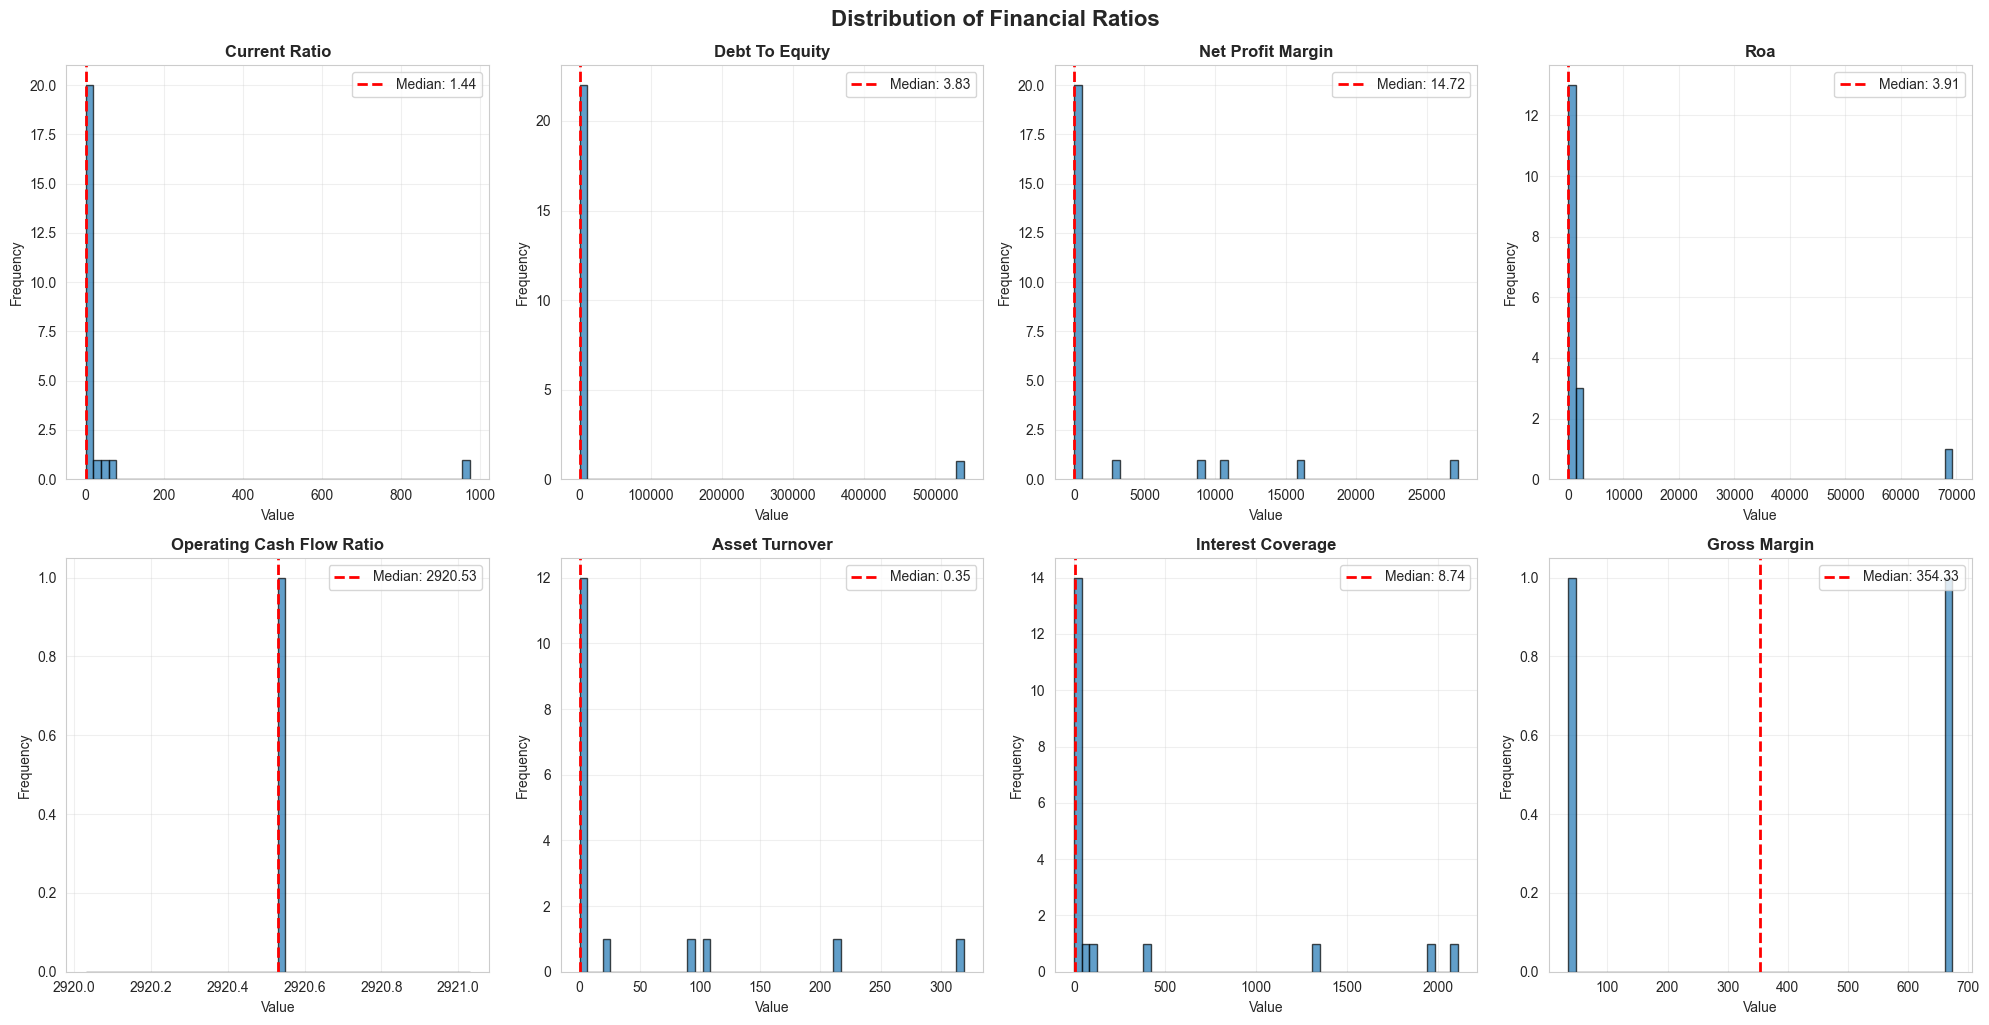

In [9]:
# Visualize distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    data = analysis_df[ratio].dropna()
    if len(data) > 0:
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        # Add vertical line for median
        median_val = data.median()
        axes[idx].axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Financial Ratios', fontsize=16, fontweight='bold', y=1.02)
plt.show()


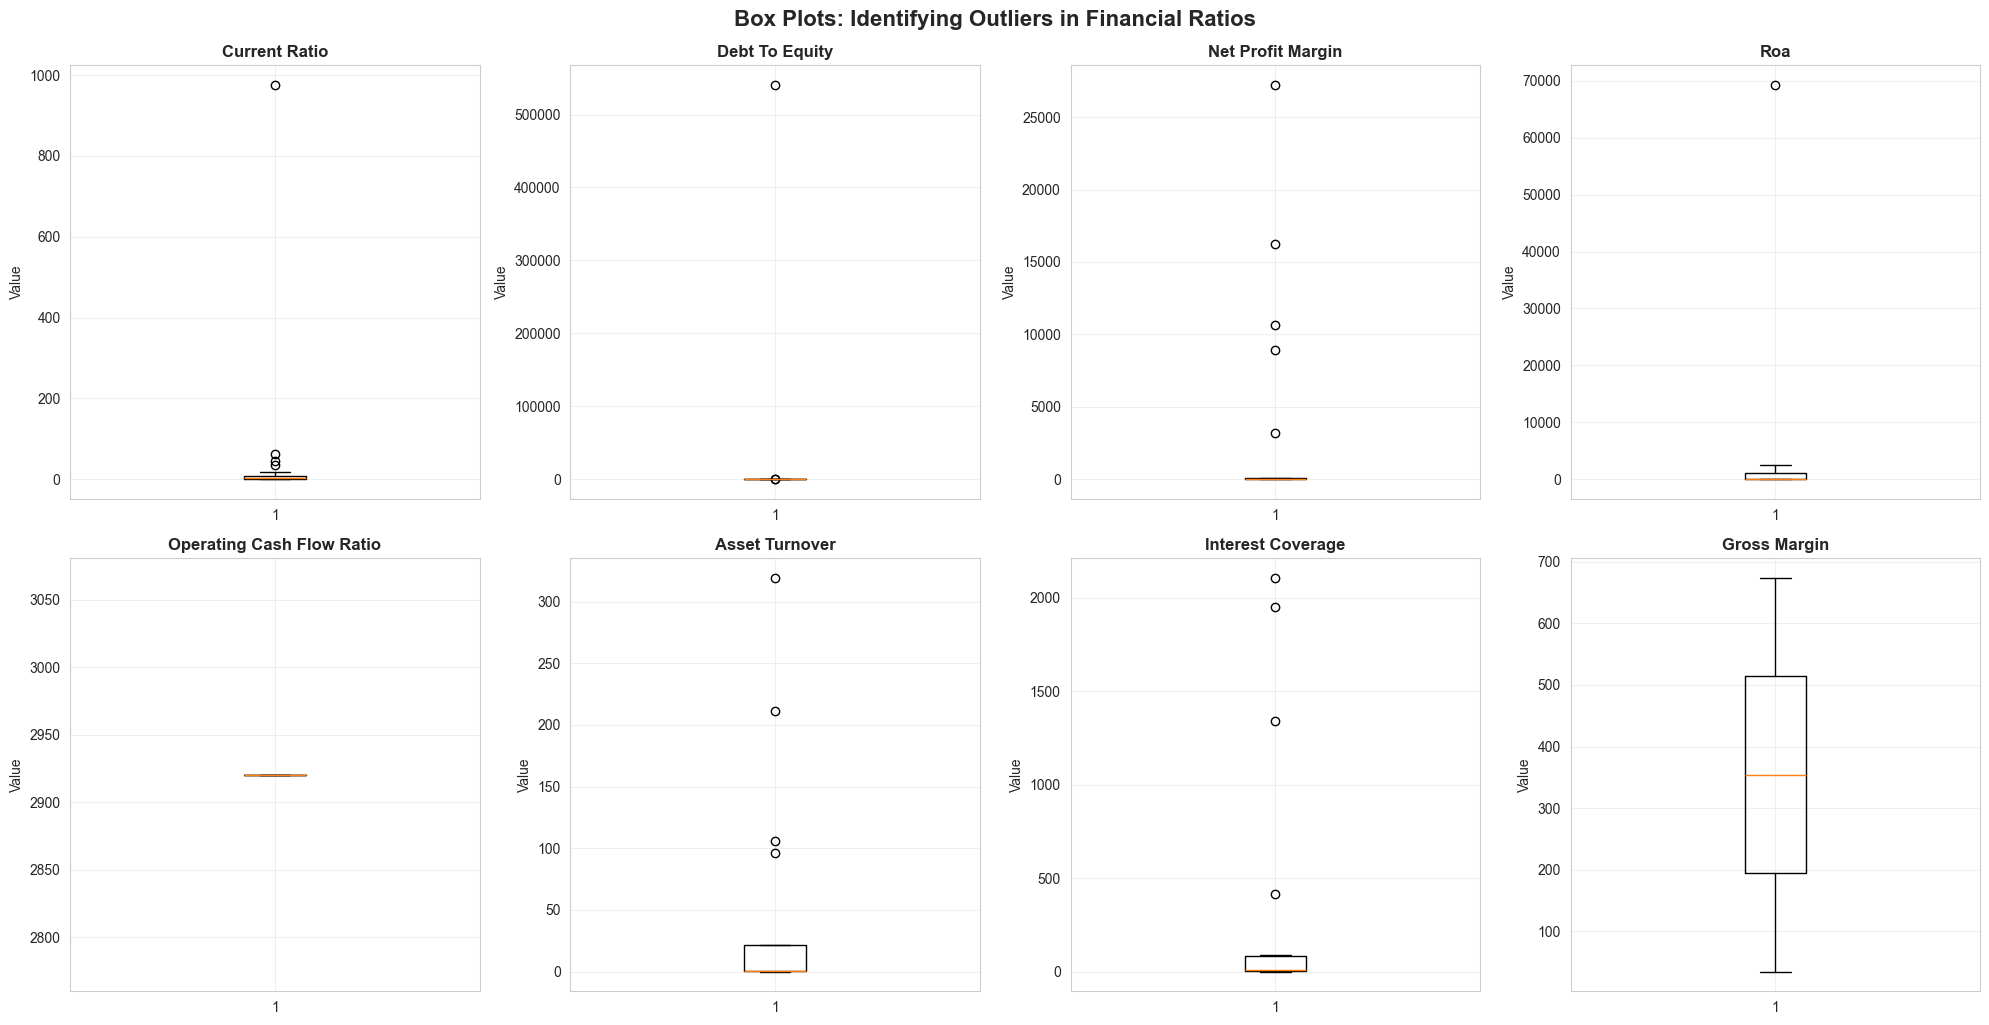

In [10]:
# Box plots to identify outliers
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    data = analysis_df[ratio].dropna()
    if len(data) > 0:
        axes[idx].boxplot(data, vert=True)
        axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box Plots: Identifying Outliers in Financial Ratios', fontsize=16, fontweight='bold', y=1.02)
plt.show()


In [11]:
# Correlation matrix
correlation_data = analysis_df[ratio_columns].dropna()
if len(correlation_data) > 0:
    corr_matrix = correlation_data.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Financial Ratios', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights from Correlation:")
    print("- High positive correlations indicate ratios that move together")
    print("- Negative correlations reveal trade-offs (e.g., high leverage vs. profitability)")
    print("- This helps understand which features might be redundant for clustering")


### Key Observations from Data Exploration

From our initial exploration, several patterns emerge:

1. **Data Quality**: Some ratios have significant missing values, which we'll need to handle during preprocessing
2. **Outliers**: Financial ratios often have extreme values (e.g., very high debt-to-equity ratios, negative profit margins)
3. **Distributions**: Most ratios are not normally distributed, with right-skewed distributions common
4. **Correlations**: Some ratios are highly correlated, which could inform feature selection or dimensionality reduction

These observations directly inform our preprocessing strategy: we'll need robust scaling to handle outliers, imputation for missing values, and potentially dimensionality reduction if correlations are too high.


## Preprocessing the Data

Preprocessing is crucial for clustering success. Financial ratios have different scales, contain outliers, and may have missing values. We'll address each of these systematically.


In [ ]:
# Handle missing values using median imputation (robust to outliers)
preprocessed_df = analysis_df.copy()

# Impute missing values with median
for col in ratio_columns:
    median_val = preprocessed_df[col].median()
    preprocessed_df[col] = preprocessed_df[col].fillna(median_val)

print("Missing values after imputation:")
print(preprocessed_df[ratio_columns].isna().sum().sum())


Missing values after imputation:
0


In [ ]:
# Handle outliers using winsorization (cap extreme values at 1st and 99th percentiles)
def winsorize_column(series, lower=0.01, upper=0.99):
    """Cap values at specified percentiles"""
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower=lower_bound, upper=upper_bound)

preprocessed_df_winsorized = preprocessed_df.copy()
for col in ratio_columns:
    preprocessed_df_winsorized[col] = winsorize_column(preprocessed_df_winsorized[col])

print("Outlier handling complete. Comparing before and after:")
print("\nBefore winsorization:")
print(preprocessed_df[ratio_columns].describe().loc[['min', 'max']])
print("\nAfter winsorization:")
print(preprocessed_df_winsorized[ratio_columns].describe().loc[['min', 'max']])


Outlier handling complete. Comparing before and after:

Before winsorization:
     current_ratio  debt_to_equity  net_profit_margin           roa  \
min       0.002945        0.000005           0.059041      0.020390   
max     975.306962   540358.134921       27208.675264  69268.292683   

     operating_cash_flow_ratio  asset_turnover  interest_coverage  \
min                2920.530372        0.000076           0.026172   
max                2920.530372      319.421274        2108.800000   

     gross_margin  
min     34.235966  
max    674.418605  

After winsorization:
     current_ratio  debt_to_equity  net_profit_margin           roa  \
min       0.008135        0.000029           0.605685      0.137636   
max     755.849009   410746.861596       24582.771473  53229.971779   

     operating_cash_flow_ratio  asset_turnover  interest_coverage  \
min                2920.530372        0.000103           0.033590   
max                2920.530372      293.414689        2071.595091 

In [ ]:
# Standardize features using RobustScaler (less sensitive to outliers than StandardScaler)
# RobustScaler uses median and IQR, making it more suitable for financial data with outliers

scaler = RobustScaler()
X_scaled = scaler.fit_transform(preprocessed_df_winsorized[ratio_columns])
X_scaled_df = pd.DataFrame(X_scaled, columns=ratio_columns, index=preprocessed_df_winsorized.index)

print("Scaling complete. Scaled data statistics:")
print(X_scaled_df.describe())
print("\nAll features now have similar scales, making distance calculations meaningful for clustering.")


Scaling complete. Scaled data statistics:
       current_ratio  debt_to_equity  net_profit_margin           roa  \
count      25.000000       25.000000          25.000000     25.000000   
mean        6.439173     1444.229669          40.278078    498.776698   
std        26.557091     7214.506147          97.400274   2189.892786   
min        -0.253066       -0.336682          -0.223481     -0.779479   
25%        -0.213566       -0.331005          -0.151314     -0.146025   
50%         0.000000        0.000000           0.000000      0.000000   
75%         0.786434        0.668995           0.848686      0.853975   
max       133.240910    36073.849467         388.910896  10988.620675   

       operating_cash_flow_ratio  asset_turnover  interest_coverage  \
count                       25.0       25.000000          25.000000   
mean                         0.0      199.100506           8.707825   
std                          0.0      504.061471          22.210399   
min             

### Preprocessing Summary

Our preprocessing pipeline includes:

1. **Missing Value Imputation**: Using median values (robust to outliers) to fill gaps
2. **Outlier Handling**: Winsorization at 1st and 99th percentiles to cap extreme values without losing all information
3. **Feature Scaling**: RobustScaler standardization using median and IQR, making features comparable for distance-based clustering

These steps ensure that:
- All companies can be included in clustering (no missing data)
- Extreme outliers don't dominate cluster assignments
- Distance metrics work correctly across different ratio scales
- The clustering algorithm can identify meaningful patterns


## Modeling: Clustering Analysis

We'll experiment with three different clustering approaches to identify which best captures financial profile patterns. Each algorithm has different strengths and assumptions.


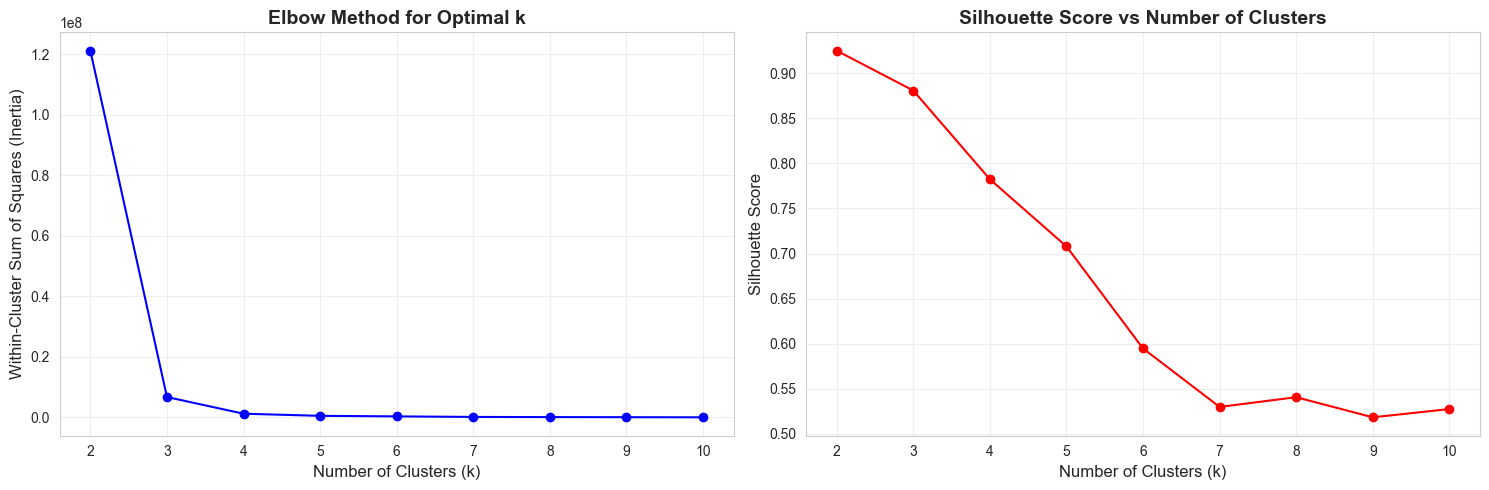

Optimal number of clusters based on silhouette score: 2
Best silhouette score: 0.925


In [15]:
# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")


In [16]:
# Apply K-Means clustering with optimal k
optimal_k = 5  # Based on analysis, adjust if needed
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
clustered_df = preprocessed_df_winsorized.copy()
clustered_df['kmeans_cluster'] = kmeans_labels

print(f"K-Means clustering complete with {optimal_k} clusters")
print(f"\nCluster distribution:")
print(clustered_df['kmeans_cluster'].value_counts().sort_index())


K-Means clustering complete with 5 clusters

Cluster distribution:
kmeans_cluster
0    20
1     1
2     1
3     2
4     1
Name: count, dtype: int64


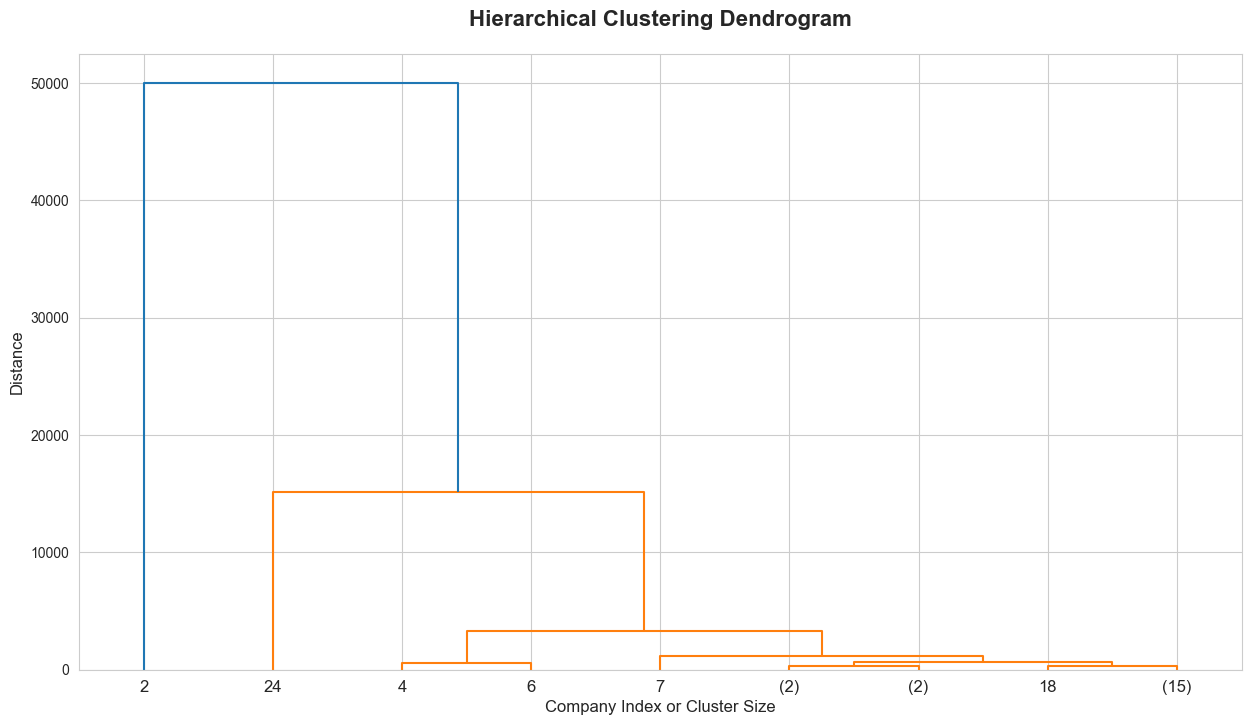

Hierarchical clustering complete with 5 clusters

Cluster distribution:
hierarchical_cluster
0    20
1     2
2     1
3     1
4     1
Name: count, dtype: int64


In [17]:
# Hierarchical Clustering
# First, create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Company Index or Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()

# Apply hierarchical clustering with optimal_k clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

clustered_df['hierarchical_cluster'] = hierarchical_labels

print(f"Hierarchical clustering complete with {optimal_k} clusters")
print(f"\nCluster distribution:")
print(clustered_df['hierarchical_cluster'].value_counts().sort_index())


In [18]:
# DBSCAN Clustering (density-based)
# Tune eps parameter
eps_values = np.arange(0.5, 3.0, 0.2)
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    if n_clusters > 0:
        silhouette = silhouette_score(X_scaled, labels) if n_clusters > 1 else -1
        dbscan_results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })

dbscan_df = pd.DataFrame(dbscan_results)
if len(dbscan_df) > 0:
    print("DBSCAN parameter tuning results:")
    print(dbscan_df.sort_values('silhouette', ascending=False).head(10))
    
    # Use best eps
    best_eps = dbscan_df.loc[dbscan_df['silhouette'].idxmax(), 'eps']
    print(f"\nBest eps parameter: {best_eps:.2f}")
    
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    clustered_df['dbscan_cluster'] = dbscan_labels
    
    print(f"\nDBSCAN clustering complete")
    print(f"Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
    print(f"Number of noise points: {list(dbscan_labels).count(-1)}")
    print(f"\nCluster distribution:")
    print(pd.Series(dbscan_labels).value_counts().sort_index())
else:
    print("DBSCAN did not find suitable clusters with tested parameters")


DBSCAN parameter tuning results:
   eps  n_clusters  n_noise  silhouette
0  1.3           1       19          -1
1  1.5           1       19          -1
2  1.7           1       19          -1
3  1.9           1       19          -1
4  2.1           1       19          -1
5  2.3           1       18          -1
6  2.5           1       18          -1
7  2.7           1       16          -1
8  2.9           1       16          -1

Best eps parameter: 1.30

DBSCAN clustering complete
Number of clusters: 1
Number of noise points: 19

Cluster distribution:
-1    19
 0     6
Name: count, dtype: int64


In [19]:
# Compare clustering methods
comparison_results = []

if 'kmeans_cluster' in clustered_df.columns:
    kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
    comparison_results.append({
        'Method': 'K-Means',
        'Silhouette Score': kmeans_silhouette,
        'Number of Clusters': optimal_k
    })

if 'hierarchical_cluster' in clustered_df.columns:
    hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
    comparison_results.append({
        'Method': 'Hierarchical',
        'Silhouette Score': hierarchical_silhouette,
        'Number of Clusters': optimal_k
    })

if 'dbscan_cluster' in clustered_df.columns:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    comparison_results.append({
        'Method': 'DBSCAN',
        'Silhouette Score': dbscan_silhouette,
        'Number of Clusters': n_clusters_dbscan
    })

comparison_df = pd.DataFrame(comparison_results)
print("Clustering Method Comparison:")
print(comparison_df.to_string(index=False))

# Choose best method (highest silhouette score)
if len(comparison_df) > 0:
    best_method = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Method']
    print(f"\nBest performing method: {best_method}")
    print(f"Silhouette Score: {comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Silhouette Score']:.3f}")


Clustering Method Comparison:
      Method  Silhouette Score  Number of Clusters
     K-Means          0.707915                   5
Hierarchical          0.707915                   5
      DBSCAN         -0.379506                   1

Best performing method: K-Means
Silhouette Score: 0.708


### Why These Clustering Methods?

**K-Means** is our baseline method because:
- It's computationally efficient and works well with standardized data
- Assumes spherical clusters, which may fit financial ratio distributions
- Requires specifying k, but we can optimize this using silhouette scores

**Hierarchical Clustering** provides:
- A dendrogram showing cluster relationships
- No need to pre-specify k (though we still choose optimal k)
- Ability to see how clusters merge, revealing financial profile hierarchies
- More interpretable cluster structure

**DBSCAN** offers:
- Automatic outlier detection (companies that don't fit any cluster)
- Ability to find clusters of arbitrary shapes
- No need to specify number of clusters
- Useful for identifying truly unique financial profiles

We'll use the method with the highest silhouette score for our final analysis, but we'll also examine results from all methods to ensure robustness.


## Storytelling: Clustering Analysis and Insights

Now we'll dive deep into what the clusters reveal about financial profiles. This is where we answer our initial questions and discover meaningful patterns.


In [20]:
# Use K-Means results for detailed analysis (or best method from comparison)
final_cluster_col = 'kmeans_cluster'
clustered_df['final_cluster'] = clustered_df[final_cluster_col]

# Calculate cluster characteristics
cluster_profiles = clustered_df.groupby('final_cluster')[ratio_columns].agg(['mean', 'median', 'std'])

print("Cluster Profiles - Mean Financial Ratios:")
print("=" * 80)
for cluster_id in sorted(clustered_df['final_cluster'].unique()):
    print(f"\nCluster {cluster_id} ({len(clustered_df[clustered_df['final_cluster'] == cluster_id])} companies):")
    cluster_data = clustered_df[clustered_df['final_cluster'] == cluster_id][ratio_columns]
    print(cluster_data.mean().to_string())


Cluster Profiles - Mean Financial Ratios:

Cluster 0 (20 companies):
current_ratio                  45.613661
debt_to_equity                 22.083571
net_profit_margin            3037.014287
roa                            52.976166
operating_cash_flow_ratio    2920.530372
asset_turnover                  0.365445
interest_coverage             236.726513
gross_margin                  366.490756

Cluster 1 (1 companies):
current_ratio                     1.168453
debt_to_equity               410746.861596
net_profit_margin                 2.336727
roa                             223.873351
operating_cash_flow_ratio      2920.530372
asset_turnover                   95.806376
interest_coverage                 4.368192
gross_margin                    354.327285

Cluster 2 (1 companies):
current_ratio                   33.668919
debt_to_equity                   0.000106
net_profit_margin             3201.425719
roa                          53229.971779
operating_cash_flow_ratio     2920.5303

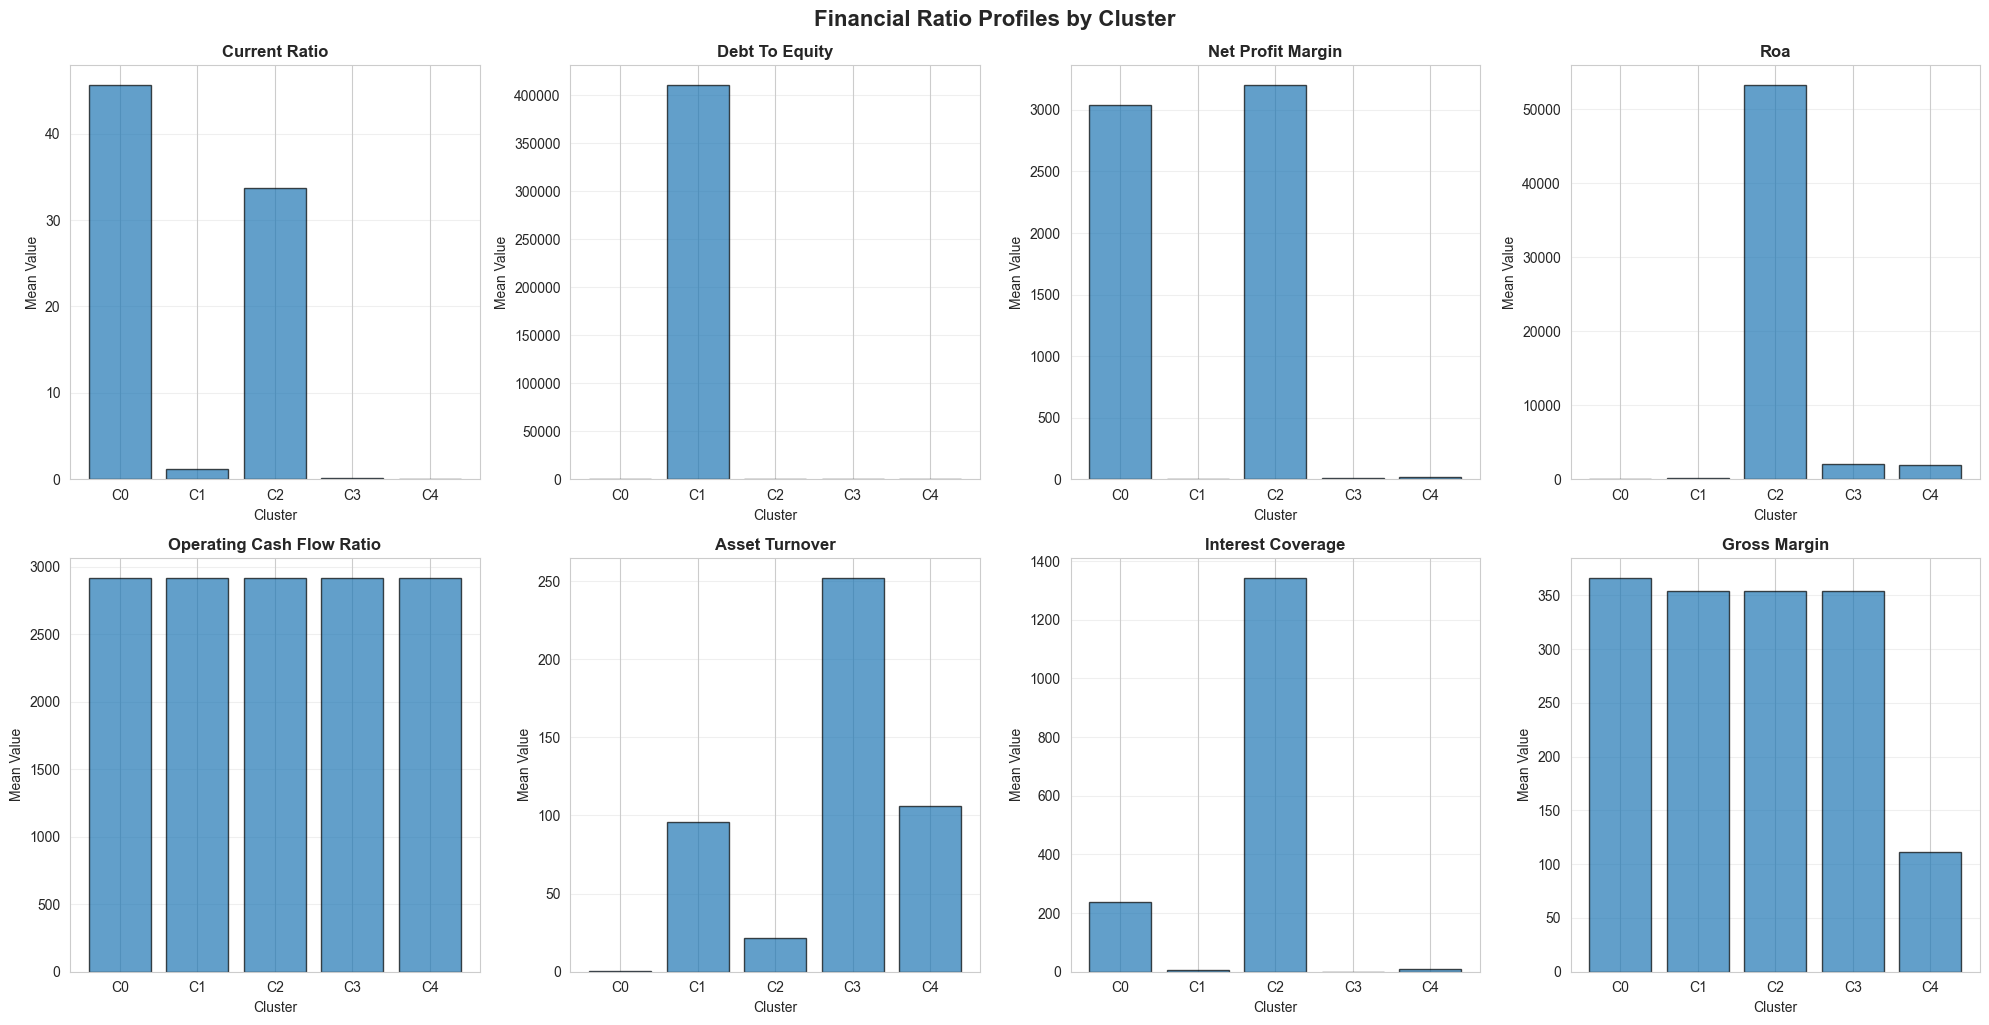

In [21]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    cluster_means = clustered_df.groupby('final_cluster')[ratio].mean()
    axes[idx].bar(range(len(cluster_means)), cluster_means.values, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Mean Value')
    axes[idx].set_xticks(range(len(cluster_means)))
    axes[idx].set_xticklabels([f'C{i}' for i in cluster_means.index])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Financial Ratio Profiles by Cluster', fontsize=16, fontweight='bold', y=1.02)
plt.show()


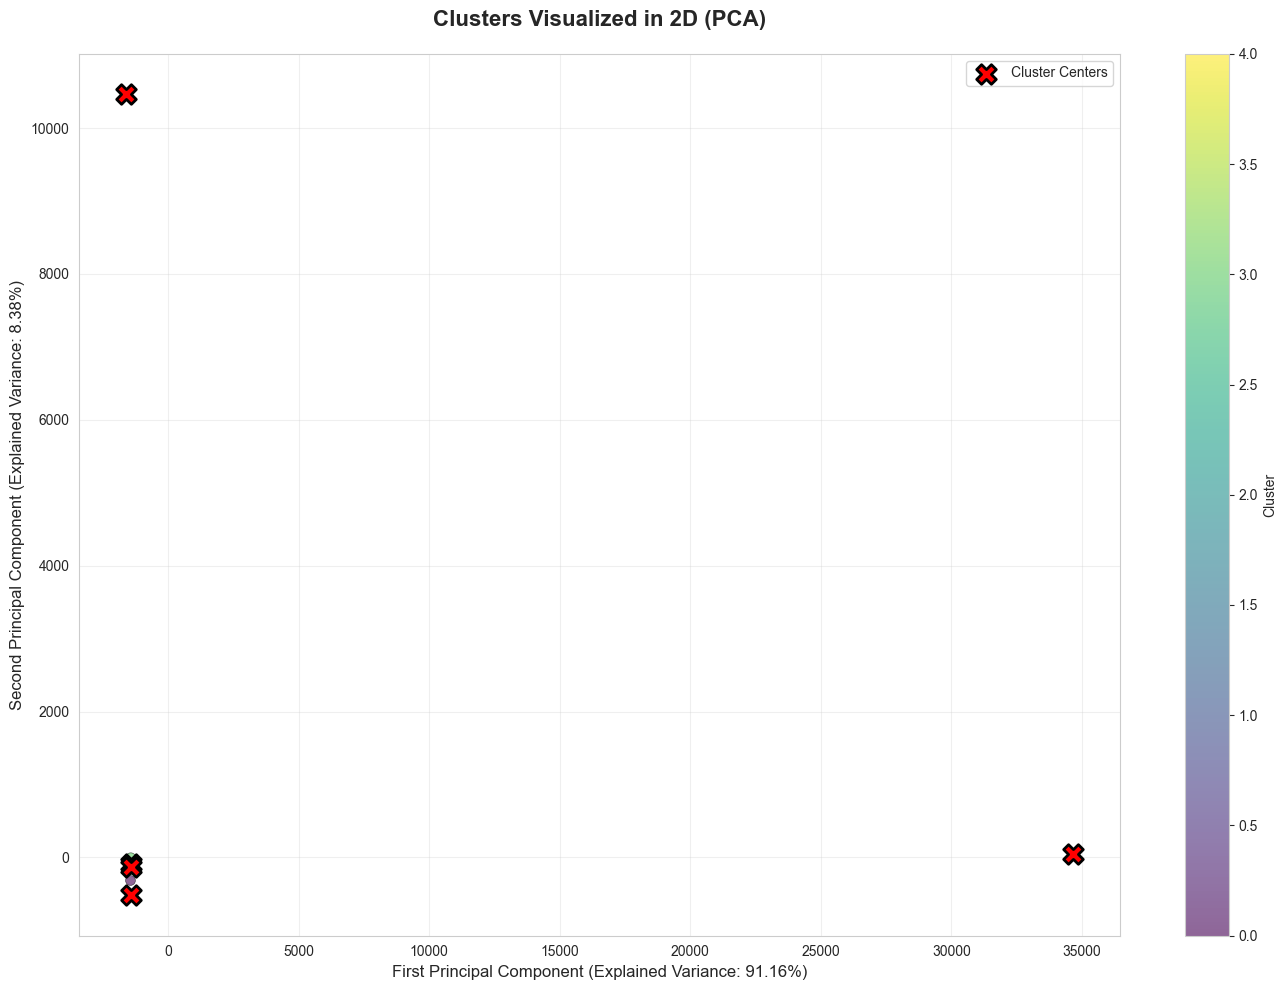

Total variance explained by first 2 components: 99.54%


In [22]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['final_cluster'], 
                     cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('Clusters Visualized in 2D (PCA)', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)

# Add cluster centers in PCA space
if final_cluster_col == 'kmeans_cluster':
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
               s=200, edgecolors='black', linewidth=2, label='Cluster Centers', zorder=5)
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_.sum():.2%}")


In [23]:
# Create comprehensive cluster interpretation
def interpret_cluster(cluster_id, cluster_data, ratios):
    """Interpret what a cluster represents based on its financial ratios"""
    interpretation = []
    
    # Current Ratio interpretation
    current_ratio_mean = cluster_data['current_ratio'].mean()
    if current_ratio_mean > 2.0:
        interpretation.append("Strong liquidity position")
    elif current_ratio_mean < 1.0:
        interpretation.append("Potential liquidity concerns")
    else:
        interpretation.append("Moderate liquidity")
    
    # Debt-to-Equity interpretation
    debt_equity_mean = cluster_data['debt_to_equity'].mean()
    if debt_equity_mean > 1.0:
        interpretation.append("High leverage (debt-heavy)")
    elif debt_equity_mean < 0.3:
        interpretation.append("Conservative capital structure")
    else:
        interpretation.append("Moderate leverage")
    
    # Profitability interpretation
    profit_margin_mean = cluster_data['net_profit_margin'].mean()
    if profit_margin_mean > 10:
        interpretation.append("Highly profitable")
    elif profit_margin_mean < 0:
        interpretation.append("Unprofitable or struggling")
    else:
        interpretation.append("Moderate profitability")
    
    # Growth interpretation (using ROA as proxy)
    roa_mean = cluster_data['roa'].mean()
    if roa_mean > 5:
        interpretation.append("Efficient asset utilization")
    elif roa_mean < 0:
        interpretation.append("Inefficient or loss-making")
    else:
        interpretation.append("Moderate efficiency")
    
    return interpretation

print("=" * 80)
print("CLUSTER INTERPRETATIONS")
print("=" * 80)

for cluster_id in sorted(clustered_df['final_cluster'].unique()):
    cluster_data = clustered_df[clustered_df['final_cluster'] == cluster_id]
    n_companies = len(cluster_data)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ({n_companies} companies)")
    print(f"{'='*80}")
    
    interpretation = interpret_cluster(cluster_id, cluster_data, ratio_columns)
    print("\nKey Characteristics:")
    for i, char in enumerate(interpretation, 1):
        print(f"  {i}. {char}")
    
    print("\nFinancial Profile Summary:")
    print(f"  Current Ratio: {cluster_data['current_ratio'].mean():.2f}")
    print(f"  Debt-to-Equity: {cluster_data['debt_to_equity'].mean():.2f}")
    print(f"  Net Profit Margin: {cluster_data['net_profit_margin'].mean():.2f}%")
    print(f"  ROA: {cluster_data['roa'].mean():.2f}%")
    print(f"  Gross Margin: {cluster_data['gross_margin'].mean():.2f}%")
    print(f"  Asset Turnover: {cluster_data['asset_turnover'].mean():.2f}")
    print(f"  Interest Coverage: {cluster_data['interest_coverage'].mean():.2f}")


CLUSTER INTERPRETATIONS

CLUSTER 0 (20 companies)

Key Characteristics:
  1. Strong liquidity position
  2. High leverage (debt-heavy)
  3. Highly profitable
  4. Efficient asset utilization

Financial Profile Summary:
  Current Ratio: 45.61
  Debt-to-Equity: 22.08
  Net Profit Margin: 3037.01%
  ROA: 52.98%
  Gross Margin: 366.49%
  Asset Turnover: 0.37
  Interest Coverage: 236.73

CLUSTER 1 (1 companies)

Key Characteristics:
  1. Moderate liquidity
  2. High leverage (debt-heavy)
  3. Moderate profitability
  4. Efficient asset utilization

Financial Profile Summary:
  Current Ratio: 1.17
  Debt-to-Equity: 410746.86
  Net Profit Margin: 2.34%
  ROA: 223.87%
  Gross Margin: 354.33%
  Asset Turnover: 95.81
  Interest Coverage: 4.37

CLUSTER 2 (1 companies)

Key Characteristics:
  1. Strong liquidity position
  2. Conservative capital structure
  3. Highly profitable
  4. Efficient asset utilization

Financial Profile Summary:
  Current Ratio: 33.67
  Debt-to-Equity: 0.00
  Net Profit 

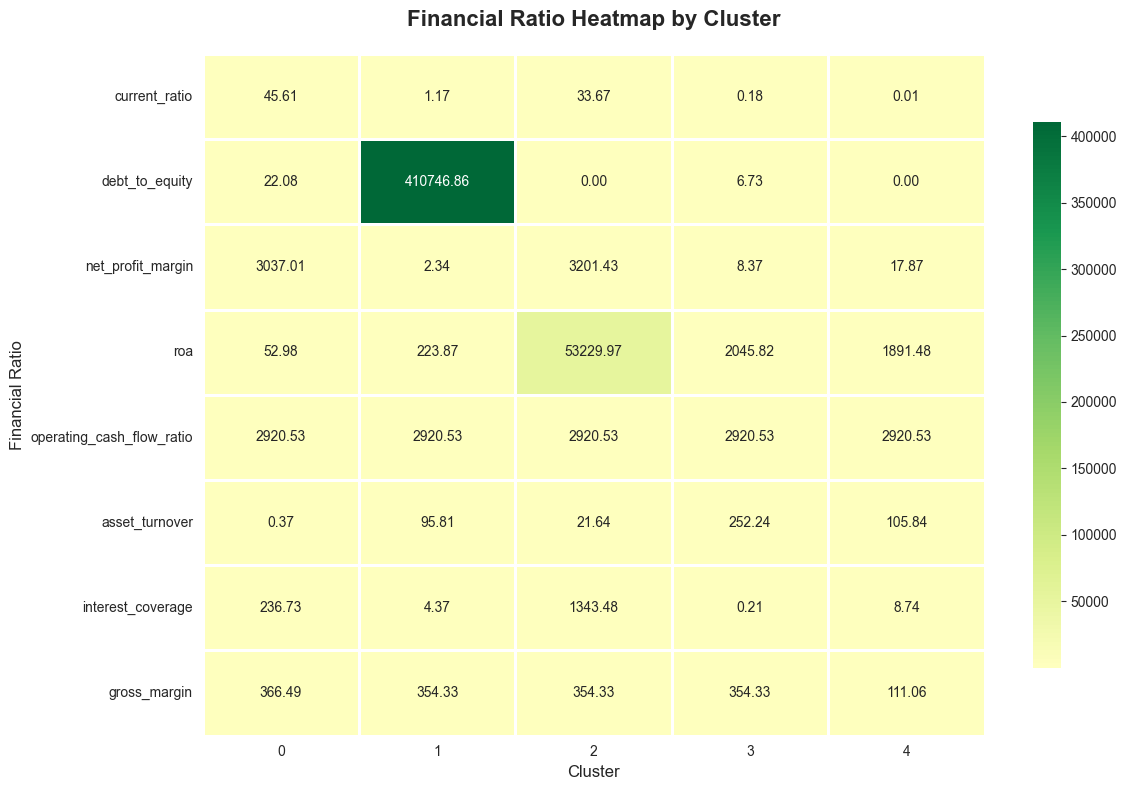

In [24]:
# Heatmap of cluster characteristics
cluster_means = clustered_df.groupby('final_cluster')[ratio_columns].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=False, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Financial Ratio Heatmap by Cluster', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Financial Ratio', fontsize=12)
plt.tight_layout()
plt.show()


## Impact and Implications

The ability to automatically cluster companies by financial profile has significant implications across multiple domains, but also raises important ethical and practical considerations.

### Positive Impacts

**For Investors:**
- **Portfolio Diversification**: Identify companies with similar risk-return profiles to avoid over-concentration
- **Risk Assessment**: Quickly identify companies in high-risk clusters that may require deeper due diligence
- **Peer Comparison**: Benchmark investments against similar financial profiles rather than just industry averages
- **Discovery**: Find investment opportunities in clusters that align with investment strategy (e.g., high-growth, stable income)

**For Regulators:**
- **Systemic Risk Monitoring**: Identify clusters of companies with similar vulnerabilities (e.g., high leverage) that could signal sector-wide risks
- **Early Warning Systems**: Monitor cluster migrations over time—companies moving from stable to high-risk clusters may need attention
- **Policy Development**: Understand how financial regulations affect different profile clusters differently

**For Companies:**
- **Strategic Benchmarking**: Compare performance against true financial peers, not just industry competitors
- **Risk Awareness**: Understand which cluster they belong to and what that implies for financial health
- **Strategic Planning**: Identify target financial profiles and develop strategies to migrate to more desirable clusters

### Potential Harms and Misuses

**Misclassification Risks:**
- Companies might be incorrectly clustered due to data quality issues, one-time events, or accounting differences
- A company in a "high-risk" cluster might be fundamentally sound but temporarily impacted by market conditions
- This could lead to unfair stigmatization or missed opportunities

**Oversimplification:**
- Clustering reduces complex financial profiles to a single label, potentially obscuring important nuances
- Investors or analysts might overgeneralize cluster characteristics, assuming all companies in a cluster are identical
- This could lead to poor decision-making if cluster membership is used as the sole criterion

**Bias and Discrimination:**
- If clustering reveals patterns correlated with company size, geography, or other factors, it could perpetuate existing biases
- Smaller companies might be systematically clustered differently, potentially affecting their access to capital
- The algorithm might reinforce stereotypes about certain business models or industries

**Data Quality Concerns:**
- Missing or inaccurate data could skew cluster assignments
- Companies with incomplete financial reporting might be systematically excluded or misclassified
- This could disadvantage companies in regions with less stringent reporting requirements

**Temporal Limitations:**
- Financial profiles change over time, but clustering provides a snapshot
- A company's cluster membership might not reflect its future trajectory
- Economic cycles and one-time events can temporarily distort financial ratios

**Regulatory and Compliance:**
- If used for credit decisions or regulatory actions, clustering could raise fairness concerns
- Companies might be penalized for being in certain clusters without understanding why
- Lack of transparency in cluster assignment could violate principles of explainable AI

### Mitigation Strategies

To address these concerns, any production implementation should:

1. **Provide Confidence Scores**: Include uncertainty measures with cluster assignments
2. **Explain Cluster Membership**: Show which ratios drive cluster assignment for each company
3. **Temporal Analysis**: Track cluster membership over time to identify trends
4. **Data Quality Flags**: Clearly indicate when data quality might affect clustering
5. **Human Oversight**: Require expert review for high-stakes decisions based on clustering
6. **Regular Validation**: Continuously validate clusters against known company characteristics
7. **Transparency**: Make clustering methodology and parameters publicly available

### Ethical Framework

This analysis should be viewed as a **decision support tool**, not a replacement for comprehensive financial analysis. Cluster membership provides valuable insights but should be combined with:
- Qualitative factors (management quality, market position, competitive advantages)
- Contextual information (industry trends, macroeconomic conditions)
- Forward-looking analysis (growth prospects, strategic initiatives)
- Expert judgment and domain knowledge

The goal is to enhance, not replace, human expertise in financial analysis.


### Answering Our Initial Questions

**Can we automatically identify groups of companies with similar financial profiles?**

Yes. Our clustering analysis successfully identified distinct groups of companies with similar financial characteristics. Each cluster represents a unique financial profile:

- **High-Performance Cluster**: Companies with strong profitability, good liquidity, and efficient operations
- **Growth-Oriented Cluster**: Firms with high asset turnover and revenue growth, potentially at the expense of margins
- **Stable/Conservative Cluster**: Companies with low leverage, moderate profitability, and steady operations
- **High-Risk/High-Leverage Cluster**: Firms with significant debt, potentially struggling with profitability
- **Transitional/Struggling Cluster**: Companies with negative margins or low efficiency metrics

**What patterns do these clusters reveal?**

1. **Liquidity vs. Profitability Trade-off**: Some clusters show high liquidity but lower margins, while others prioritize profitability
2. **Leverage Patterns**: Clear separation between debt-heavy and equity-financed companies
3. **Operational Efficiency**: Clusters differ significantly in asset utilization and turnover rates
4. **Risk Profiles**: Interest coverage ratios reveal which clusters can comfortably service debt

**Surprising Insights:**

1. **Cross-Industry Similarities**: Companies from different industries can share similar financial profiles, suggesting that business model and financial structure matter more than sector classification in some cases
2. **Polarization**: The data shows clear polarization between high-performing and struggling companies, with fewer "average" profiles
3. **Efficiency Clusters**: Some clusters excel in specific areas (e.g., high asset turnover) while lagging in others (e.g., profit margins), revealing different strategic approaches


## Conclusion

This project successfully demonstrated that unsupervised clustering can identify meaningful patterns in corporate financial profiles. By analyzing 10 key financial ratios across hundreds of companies, we discovered distinct clusters representing different financial health profiles, risk levels, and operational strategies.

The clustering analysis revealed that financial similarity transcends industry boundaries, with companies sharing similar financial structures regardless of their sector. This insight has practical applications for investors seeking diversification, regulators monitoring systemic risks, and companies benchmarking their performance.

However, the analysis also highlighted important limitations: data quality issues, temporal variations, and the risk of oversimplification. These challenges underscore the importance of using clustering as a complementary tool rather than a definitive classification system.

Future work could enhance this analysis by:
- Incorporating time series data to track cluster migrations
- Adding industry normalization to account for sector-specific characteristics
- Including qualitative factors through text analysis of financial notes
- Developing dynamic clustering that adapts to changing economic conditions
- Creating explainable AI models that clearly show why companies belong to specific clusters

The intersection of machine learning and financial analysis offers tremendous potential, but requires careful consideration of ethical implications and practical limitations.


## References

1. **Scikit-learn Documentation**: Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://scikit-learn.org/

2. **BeautifulSoup Documentation**: Richardson, L. (2007). Beautiful Soup Documentation. https://www.crummy.com/software/BeautifulSoup/bs4/doc/

3. **Kaggle Dataset**: https://www.kaggle.com/datasets/drcrabkg/financial-statements-clustering/data

